# Data mapping

In [149]:
%matplotlib inline

import seaborn as sns
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

For this tutorial, we will use the recently released Index of Multiple Deprivation from 2015.

* How to download it ([link](https://data.cdrc.ac.uk/dataset/cdrc-english-indices-of-deprivation-2015-geodata-pack-liverpool-e08000012)).
* Download background from the course website (link).

In [151]:
# This will be different on your computer and will depend on where
# you have downloaded the files
imd_shp = '../../../../data/E08000012_IMD/shapefiles/E08000012.shp'
bkg_path = 'figs/lab04_liverpool_color.tif'

Load the IMD data:

In [152]:
imd = gpd.read_file(imd_shp).set_index('LSOA11CD')
imd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 298 entries, E01006512 to E01033768
Data columns (total 12 columns):
crime         298 non-null float64
education     298 non-null float64
employment    298 non-null float64
geometry      298 non-null object
health        298 non-null float64
housing       298 non-null float64
idaci         298 non-null float64
idaopi        298 non-null float64
imd_rank      298 non-null int64
imd_score     298 non-null float64
income        298 non-null float64
living_env    298 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 30.3+ KB


## Unique values

## Equal interval

In [173]:
classi = ps.Equal_Interval(imd['imd_rank'], k=7)
classi

                 Equal Interval                
 
  Lower              Upper                Count
            x[i] <=  4604.857               156
 4604.857 < x[i] <=  9185.714                48
 9185.714 < x[i] <= 13766.571                30
13766.571 < x[i] <= 18347.429                21
18347.429 < x[i] <= 22928.286                24
22928.286 < x[i] <= 27509.143                14
27509.143 < x[i] <= 32090.000                 5

In [174]:
classi.bins

array([  4604.85714286,   9185.71428571,  13766.57142857,  18347.42857143,
        22928.28571429,  27509.14285714,  32090.        ])

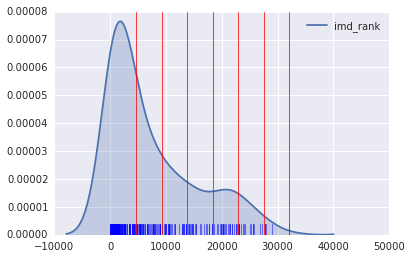

In [175]:
f, ax = plt.subplots(1)
sns.kdeplot(imd['imd_rank'], shade=True)
sns.rugplot(imd['imd_rank'], alpha=0.5)
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
plt.show()

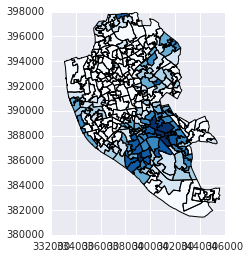

In [176]:
imd.plot(column='imd_rank', scheme='equal_interval', alpha=1, k=7, colormap=plt.cm.Blues)

## Quantiles

In [170]:
classi = ps.Quantiles(imd['imd_rank'], k=7)
classi

                  Quantiles                   
 
  Lower              Upper               Count
            x[i] <=   633.714               43
  633.714 < x[i] <=  1335.714               42
 1335.714 < x[i] <=  2641.000               43
 2641.000 < x[i] <=  5540.143               42
 5540.143 < x[i] <= 10355.857               43
10355.857 < x[i] <= 18401.143               42
18401.143 < x[i] <= 32090.000               43

In [171]:
classi.bins

array([   633.71428571,   1335.71428571,   2641.        ,   5540.14285714,
        10355.85714286,  18401.14285714,  32090.        ])

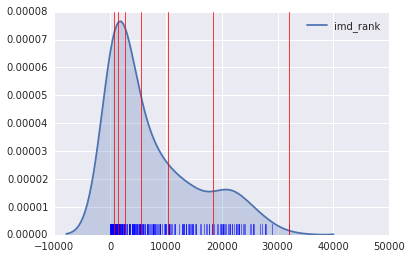

In [172]:
f, ax = plt.subplots(1)
sns.kdeplot(imd['imd_rank'], shade=True)
sns.rugplot(imd['imd_rank'], alpha=0.5)
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
plt.show()

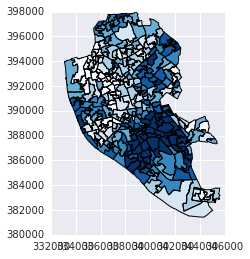

In [160]:
imd.plot(column='imd_rank', scheme='QUANTILES', alpha=1, k=7, colormap=plt.cm.Blues)

## Fisher-Jenks

In [165]:
classi = ps.Fisher_Jenks(imd['imd_rank'], k=7)
classi

                  Fisher_Jenks                 
 
  Lower              Upper                Count
            x[i] <=  2930.000               133
 2930.000 < x[i] <=  6946.000                52
 6946.000 < x[i] <= 11656.000                39
11656.000 < x[i] <= 16185.000                24
16185.000 < x[i] <= 20719.000                20
20719.000 < x[i] <= 24098.000                18
24098.000 < x[i] <= 32090.000                12

In [166]:
classi.bins

array([  2930.,   6946.,  11656.,  16185.,  20719.,  24098.,  32090.])

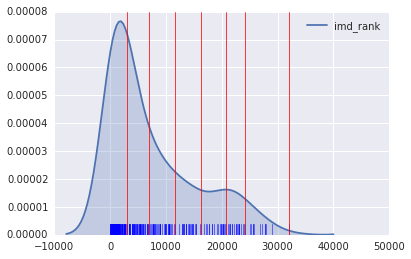

In [167]:
f, ax = plt.subplots(1)
sns.kdeplot(imd['imd_rank'], shade=True)
sns.rugplot(imd['imd_rank'], alpha=0.5)
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)
plt.show()

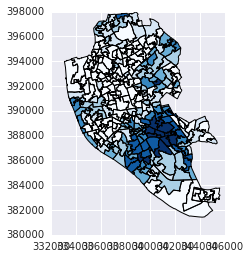

In [168]:
imd.plot(column='imd_rank', scheme='fisher_jenks', alpha=1, k=7, colormap=plt.cm.Blues)

## `[Extension 1]` Conditional maps

Check [this](http://stanford.edu/~mwaskom/software/seaborn/examples/faceted_histogram.html).